In [1]:
#import analysis
import sys
sys.path.insert(0,'../scripts/')

import test_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import subplots,scatter
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score
#from yellowbrick.features import RFECV
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost

C:\Users\Richard\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#import analysis
def read_data(file_dir,DB_file_dir):
    
    data = []
    label = []
    
    print('loading..{}'.format(file_dir))
    df=pd.read_pickle(file_dir)
    psm_ID=list(pd.read_csv(DB_file_dir)['Scan'])
    y=np.zeros(df.shape[0])

    for i in range(0,df.shape[0]):
        if df.index[i] in psm_ID:
            y[i]=1

    X = df.drop('RT',axis=1).fillna(0).values
    y =y.astype(int)[X.sum(axis=1)!=0]
    X = X[X.sum(axis=1)!=0]
    X = X/X.sum(axis=1).reshape(X.shape[0],1) #normalization
    data.append(X)
    label.append(y)
    del X

    data = np.concatenate((data))
    label = np.concatenate((label))
    return data,label

from numpy.random import randint,seed,choice
def under_sampler(data,label,n_sample):
    
    index_maj = np.where(label==0)[0]
    index_min = np.where(label==1)[0]
    
    seed(19)
    sample_index = choice(len(index_maj),size=n_sample,replace=False)
    index_maj_sampled = index_maj[sample_index]
    data_sampled = data[np.concatenate((index_maj_sampled,index_min))]
    label_sampled = label[np.concatenate((index_maj_sampled,index_min))]
    
    shuffle_index = choice(len(data_sampled),size=len(data_sampled),replace=False)
    data_sampled = data_sampled[shuffle_index]
    label_sampled = label_sampled[shuffle_index]
    
    return data_sampled,label_sampled

def load_sample_data(file_dir,DB_file_dir,n_sample):
    
    X_train,X_test,Y_train,Y_test = [],[],[],[]
    for i in range(len(file_dir)):
        data,label = read_data(file_dir[i],DB_file_dir[i])
        x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=1)
        del data
        
        x_train_sampled,y_train_sampled = under_sampler(x_train,y_train,len(y_train[y_train==1])*n_sample)
        del x_train,y_train
        X_train.append(x_train_sampled)
        X_test.append(x_test)
        Y_train.append(y_train_sampled)
        Y_test.append(y_test)
        del x_test,y_test,x_train_sampled,y_train_sampled
        
    X_train = np.concatenate(X_train)
    X_test = np.concatenate(X_test)
    Y_train = np.concatenate(Y_train)
    Y_test = np.concatenate(Y_test)

    return X_train,X_test,Y_train,Y_test

In [3]:
a=joblib.load('../Orbitrap_aplysia/ped.pkl')

In [5]:
import utils
#ped_df = utils.read_mzml('../Orbitrap_aplysia/Pedal.mzML')
#ple_df = utils.read_mzml('../Orbitrap_aplysia/Pleural.mzML')

In [ ]:
file_dir = ['../Orbitrap_aplysia/abd.pkl','../Orbitrap_aplysia/buc.pkl','../Orbitrap_aplysia/cer.pkl',
           '../Orbitrap_aplysia/ped.pkl','../Orbitrap_aplysia/ple.pkl']
DB_file_dir = ['../Aplysia_ganglia/Abdominal/DB search psm.csv','../Aplysia_ganglia/Buccal/DB search psm.csv',
              '../Aplysia_ganglia/Cerebral/DB search psm.csv','../Aplysia_ganglia/Pedal/DB search psm.csv',
              '../Aplysia_ganglia/Pleural/DB search psm.csv']

X_train,X_test,Y_train,Y_test = load_sample_data(file_dir,DB_file_dir,1)

In [ ]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7,10],
        'learning_rate':[0.1,0.05,0.01,0.005],
        'reg_alpha':[0,1e-5, 1e-2, 0.1, 1]
        }

xgb = xgboost.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=5,scale_pos_weight=scale_weight)
folds = 3
param_comb = 7

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 19)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                   n_jobs=2, cv=skf.split(X_train,y_train), verbose=3, random_state=19 )

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
scale_weight = Y_train[Y_train==0].shape[0]/Y_train[Y_train==1].shape[0]

xgb_best = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=600, objective='binary:logistic',scale_pos_weight=scale_weight,
                    subsample=1,reg_alpha=0,min_child_weight=5,max_depth=4,gamma=0,colsample_bytree=1,nthread = 8)

In [ ]:
#training GBT
xgb_best.fit(X_train,Y_train)

y_pred_xgb_best = xgb_best.predict(X_test)
y_pred_xgb_prob_best = xgb_best.predict_proba(X_test)
report_dict_xgb_best = classification_report(Y_test, y_pred_xgb_best, output_dict=True)

In [ ]:
report_dict_xgb_best

In [ ]:
#Loading trained DL model

import os
cuda_path = 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.0\\bin'
cudnn_path = 'D:\\Work\\software\\cuda\\bin'
os.environ["PATH"] += os.pathsep + cuda_path
os.environ["PATH"] += os.pathsep + cudnn_path
import keras
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)
import keras
from keras.layers import Dense, Conv1D, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling1D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

INTERESTING_CLASS_ID =  1 # Choose the class of interest

def single_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    #recall_mask = K.cast(K.equal(class_id_true, INTERESTING_CLASS_ID), 'int32')

    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    #class_recall_tensor = K.cast(K.equal(class_id_true, class_id_true), 'int32') * recall_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    #class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)
    return class_acc

def single_class_recall(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    #accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    recall_mask = K.cast(K.equal(class_id_true, INTERESTING_CLASS_ID), 'int32')

    #class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_recall_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * recall_mask
    #class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)
    return class_recall

dependencies = {
    'recall_m': recall_m,'precision_m':precision_m,'f1_m':f1_m,'single_class_accuracy':single_class_accuracy,
    'single_class_recall':single_class_recall
}

model = keras.models.load_model('../models/Abd_Buc_ResNet11v2_model.074.h5',custom_objects=dependencies)

In [ ]:
x_test_ = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
y_pred = model.predict(x_test_)

In [100]:
negative_index = np.where(y_train==0)[0]
positive_index = np.where(y_train==1)[0]

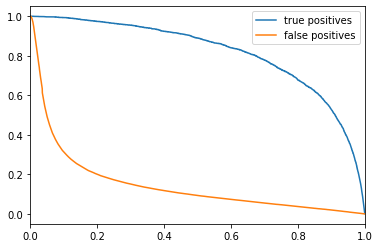

In [26]:
plt.plot(threshold_roc,tpr)
plt.plot(threshold_roc,ftp)
plt.xlim([0,1])
plt.legend(['true positives','false positives'])

Threshold cutoff:  0.83840555
Max F1-score at cut-off :  0.614280588446358


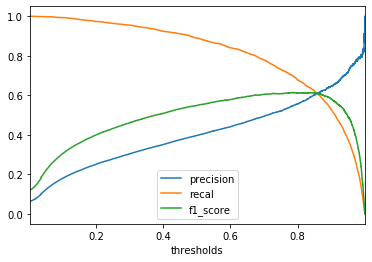

In [25]:
scrs = pd.DataFrame({'precision' : precision[1:], 'recal' : recall[1:], 'thresholds' : threshold_pr, 'f1_score':f1_scores[1:]})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())

ax = scrs.plot(x='thresholds')

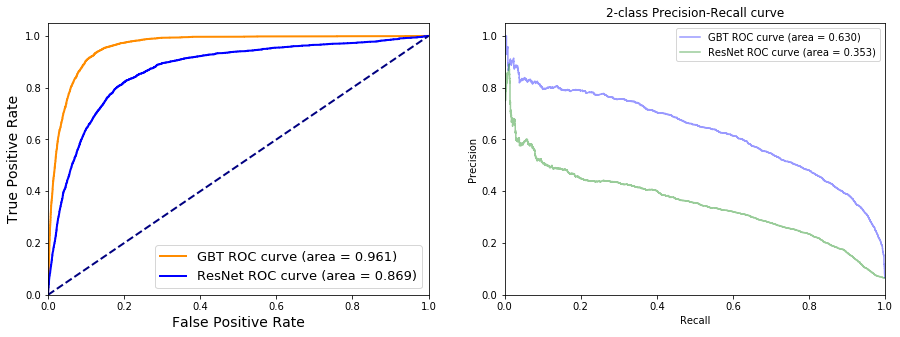

In [24]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
precision, recall, threshold_pr = precision_recall_curve(Y_test, y_pred_xgb_prob_best[:,1])

ftp,tpr,threshold_roc = roc_curve(Y_test,y_pred_xgb_prob_best[:,1])

precision2, recall2, threshold_pr2 = precision_recall_curve(Y_test, y_pred[:,1])

ftp2,tpr2,threshold_roc2 = roc_curve(Y_test,y_pred[:,1])

fig,axes = subplots(1,2,figsize=(15,5))
ax = axes.ravel()
ax[0].plot(ftp, tpr, color='darkorange',
         lw=2, label='GBT ROC curve (area = %0.3f)' % auc(ftp,tpr))
ax[0].plot(ftp2, tpr2, color='blue',
         lw=2, label='ResNet ROC curve (area = %0.3f)' % auc(ftp2,tpr2))

ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate',fontsize=14)
ax[0].set_ylabel('True Positive Rate',fontsize=14)
ax[0].legend(loc="lower right",fontsize=13)

thresholds = np.append(threshold_pr, 1)
f1_scores = 2*(precision*recall)/(precision+recall)

ax[1].plot(recall, precision, color='b', alpha=0.4,label='GBT ROC curve (area = %0.3f)' % auc(recall,precision))
ax[1].plot(recall2, precision2, color='g', alpha=0.4,label='ResNet ROC curve (area = %0.3f)' % auc(recall2,precision2))

ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlim([0.0, 1.0])
ax[1].set_title('2-class Precision-Recall curve')
ax[1].legend()

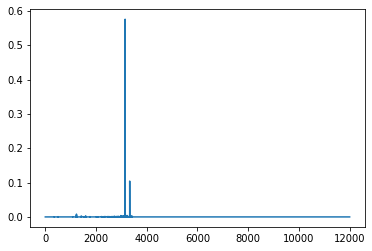

In [6]:
plt.plot(X_train[Y_train==0][512])